<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/TRANSFORMER_cammellone(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload cleaned dataset

In [ ]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()

Saving cleaned_dataset_NN.csv to cleaned_dataset_NN (1).csv


In [ ]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


In [ ]:
!pip install datasets


In [ ]:
!pip install evaluate

In [ ]:
!pip install seqeval

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer
from datasets import Dataset
import os

#Splitting the dataset and rebalancing classes

In [ ]:
save_directory = r'./saved_model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [ ]:
# Valori unici di Label
print("\nCategorie di Label:")
print(df['Label'].unique())

# Frequenza delle etichette
print("\nDistribuzione delle etichette:")
print(df['Label'].value_counts())



Categorie di Label:
['B-Multi-tissue_structure' 'O' 'B-Organism_substance'
 'B-Organism_subdivision' 'B-Organ' 'I-Multi-tissue_structure'
 'B-Cellular_component' 'I-Cellular_component' 'B-Cell' 'I-Cell'
 'B-Immaterial_anatomical_entity' 'B-Tissue' 'I-Tissue'
 'B-Pathological_formation' 'B-Anatomical_system' 'I-Organism_substance'
 'I-Anatomical_system' 'I-Pathological_formation'
 'I-Immaterial_anatomical_entity' 'I-Organ' 'I-Organism_subdivision'
 'B-Developing_anatomical_structure' 'I-Developing_anatomical_structure']

Distribuzione delle etichette:
Label
O                                    56455
B-Cell                                 775
B-Multi-tissue_structure               639
I-Cell                                 439
B-Organ                                381
B-Pathological_formation               367
I-Multi-tissue_structure               358
B-Organism_substance                   288
I-Pathological_formation               224
B-Cellular_component                   199
B-Tiss

Utilizzo di stratify per garantire che le classi siano tutte  rappresentate in proporzione nel training,test e validetion set , si utilizza in task di classificazione soprattutto nel nostro caso con un datset sbilanciato.

https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:

from sklearn.model_selection import train_test_split
# Suddivisione del dataset con stratificazione basata sulla colonna "label"
unique_ids = df['id'].unique()
labels = df.drop_duplicates('id')['label']  # Otteniamo i label univoci corrispondenti agli id

# Stratificazione per la divisione iniziale (70% train, 30% temp)
train_ids, temp_ids = train_test_split(unique_ids,test_size=0.3,random_state=42,stratify=labels)

temp_labels = labels[labels.index.isin(temp_ids)] #label associated to temporary ID

# Stratificazione per la divisione di temp in validation (15%) e test (15%)
val_ids, test_ids = train_test_split(temp_ids,test_size=0.5,random_state=42,stratify=temp_labels)

# Creiamo i DataFrame per ogni set
train_df = df[df['id'].isin(train_ids)]
val_df = df[df['id'].isin(val_ids)]
test_df = df[df['id'].isin(test_ids)]

# Controlliamo le dimensioni
print("Dimensioni dei set:")
print("Train set:", train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)


Dimensioni dei set:
Train set: (41975, 4)
Validation set: (10505, 4)
Test set: (8499, 4)


##rebalncing training set

In [ ]:
# Bilancia solo il training set
balanced_train_df = pd.DataFrame()
for label in train_df['Label'].unique():
    subset = train_df[train_df['Label'] == label]
    if len(subset) < train_df['Label'].value_counts().max():
        subset = resample(subset, replace=True, n_samples=train_df['Label'].value_counts().max(), random_state=42)
    balanced_train_df = pd.concat([balanced_train_df, subset])

# Shuffle per mescolare i dati bilanciati
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nDistribuzione delle etichette nel training set bilanciato:")
print(balanced_train_df['Label'].value_counts())


Distribuzione delle etichette nel training set bilanciato:
Label
B-Pathological_formation             38813
O                                    38813
B-Organ                              38813
I-Immaterial_anatomical_entity       38813
B-Immaterial_anatomical_entity       38813
I-Pathological_formation             38813
I-Tissue                             38813
I-Multi-tissue_structure             38813
I-Organ                              38813
I-Cellular_component                 38813
I-Anatomical_system                  38813
I-Cell                               38813
B-Cell                               38813
B-Developing_anatomical_structure    38813
B-Multi-tissue_structure             38813
I-Organism_subdivision               38813
I-Developing_anatomical_structure    38813
B-Organism_substance                 38813
B-Cellular_component                 38813
I-Organism_substance                 38813
B-Organism_subdivision               38813
B-Tissue                       

#Mapping NER tags

In [ ]:
# Creiamo una lista di tutte le etichette presenti nel training set bilanciato
all_labels = balanced_train_df['Label'].unique()

# Creiamo il mapping delle etichette
tag2id = {tag: idx for idx, tag in enumerate(all_labels)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

# Aggiungiamo la colonna con l'ID delle etichette nei dataset
balanced_train_df['Label_ID'] = balanced_train_df['Label'].map(tag2id)
val_df['Label_ID'] = val_df['Label'].map(tag2id)
test_df['Label_ID'] = test_df['Label'].map(tag2id)

# Controlliamo il mapping
print("Mapping delle etichette (tag2id):", tag2id)


Mapping delle etichette (tag2id): {'B-Pathological_formation': 0, 'O': 1, 'B-Organ': 2, 'I-Immaterial_anatomical_entity': 3, 'B-Immaterial_anatomical_entity': 4, 'I-Pathological_formation': 5, 'I-Tissue': 6, 'I-Multi-tissue_structure': 7, 'I-Organ': 8, 'I-Cellular_component': 9, 'I-Anatomical_system': 10, 'I-Cell': 11, 'B-Cell': 12, 'B-Developing_anatomical_structure': 13, 'B-Multi-tissue_structure': 14, 'I-Organism_subdivision': 15, 'I-Developing_anatomical_structure': 16, 'B-Organism_substance': 17, 'B-Cellular_component': 18, 'I-Organism_substance': 19, 'B-Organism_subdivision': 20, 'B-Tissue': 21, 'B-Anatomical_system': 22}


<ipython-input-120-a2a10882e578>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Label_ID'] = val_df['Label'].map(tag2id)
<ipython-input-120-a2a10882e578>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Label_ID'] = test_df['Label'].map(tag2id)


#Preparing Data for Hugging Face

In [ ]:
# Trasforma le etichette in ID numerici usando il mapping tag2id
def convert_labels_to_ids(df, tag2id):
    df.loc[:,'Label_ID'] = df['Label'].map(tag2id)  # Mappa direttamente i valori della colonna
    return df

# Esegui la conversione per ogni dataset
train_dataset = convert_labels_to_ids(train_df, tag2id)
val_dataset = convert_labels_to_ids(val_df, tag2id)
test_dataset = convert_labels_to_ids(test_df, tag2id)

print("Conversione delle etichette completata!")
print(train_dataset.head())

Conversione delle etichette completata!
             id  Start  End                     Label  Label_ID
0   Ventricular      0   11  B-Multi-tissue_structure        14
1  fibrillation     12   24                         O         1
3            QT     37   39                         O         1
4      syndrome     40   48                         O         1
7   clindamycin     68   79                         O         1


<ipython-input-121-bcd5c7678cc0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Label_ID'] = df['Label'].map(tag2id)  # Mappa direttamente i valori della colonna


#Dataset for Hugging Face

In [ ]:
# Converto i DataFrame in Dataset di Hugging Face
train_hf = Dataset.from_pandas(train_dataset)
val_hf = Dataset.from_pandas(val_dataset)
test_hf = Dataset.from_pandas(test_dataset)

#Loading tokenizer and pre-trained model

In [ ]:
# Carichiamo il tokenizer di DistilBERT
model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Tokenizer caricato:", model_name)

Tokenizer caricato: distilbert-base-cased


#Tokenization and labels allignment

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['id'],                # Testo da tokenizzare
        truncation=True,               # Tronca se necessario
        padding='max_length',          # Applica padding
        max_length=128,                # Lunghezza massima
        return_offsets_mapping=True,   # Mappa gli offset per i token
        is_split_into_words=False      # I token non sono pre-suddivisi
    )

    labels = []
    for i, label in enumerate(examples['Label_ID']):
        word_ids = tokenized_inputs.offset_mapping[i]
        aligned_labels = []
        for idx, word_id in enumerate(word_ids):
            if word_id is None or tokenized_inputs.input_ids[i][idx] == tokenizer.pad_token_id:
                aligned_labels.append(-100)  # Ignora token speciali e padding
            else:
                aligned_labels.append(label)  # Usa l'etichetta originale
        labels.append(aligned_labels)

    tokenized_inputs.pop("offset_mapping")  # Rimuove offset_mapping
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Applico la tokenizzazione ai dataset
def process_datasets(dataset, tokenizer):
    return dataset.map(
        tokenize_and_align_labels,
        batched=True,  # Processa in batch per velocità e robustezza
        remove_columns=['id', 'Label', 'Label_ID']  # Rimuove colonne inutili
    )


# Tokenizzazione per i tre dataset
tokenized_datasets = {}
for split, dataset in zip(["train", "validation", "test"], [train_hf, val_hf, test_hf]):
    tokenized_datasets[split] = process_datasets(dataset, tokenizer)

print("Tokenizzazione completata!")



Map:   0%|          | 0/41975 [00:00<?, ? examples/s]

Map:   0%|          | 0/10505 [00:00<?, ? examples/s]

Map:   0%|          | 0/8499 [00:00<?, ? examples/s]

Tokenizzazione completata!


In [ ]:
# Controlla un esempio del dataset tokenizzato
print("Esempio tokenizzato (Train):")
print(tokenized_datasets["train"].select(range(5)).to_dict())


Esempio tokenizzato (Train):
{'Start': [0, 12, 37, 40, 68], 'End': [11, 24, 39, 48, 79], '__index_level_0__': [0, 1, 3, 4, 7], 'input_ids': [[101, 159, 3452, 4907, 5552, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 20497, 27647, 3848, 2116, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 154, 1942, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#Model Configuration

In [ ]:
from transformers import AutoModelForTokenClassification

# Carichiamo il modello DistilBERT configurato per il token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_name,           # Nome del modello pre-addestrato
    num_labels=len(tag2id)  # Numero di classi (etichette uniche)
)

print("Modello caricato con successo!")


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modello caricato con successo!


#Preparing for training
##Data collator

In [ ]:
from transformers import DataCollatorForTokenClassification

# Configuriamo il Data Collator per il task di classificazione dei token
data_collator = DataCollatorForTokenClassification(tokenizer)
print("Data Collator configurato!")


Data Collator configurato!


In [ ]:
import evaluate
import numpy as np

# Carichiamo la libreria per le metriche
seqeval = evaluate.load("seqeval")

# Funzione per calcolare le metriche
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)  # Convertiamo le predizioni in classi

    # Escludiamo token speciali (-100)
    true_predictions = [
        [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Metriche configurate!")


Metriche configurate!


##Setting training parameters

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",          # Directory di output per i risultati
    num_train_epochs=5,              # Numero di epoche
    per_device_train_batch_size=64,  # Batch size per l'addestramento
    per_device_eval_batch_size=128,   # Batch size per la validazione
    eval_strategy="epoch",     # Valutazione alla fine di ogni epoca
    save_strategy="epoch",           # Salvataggio alla fine di ogni epoca
    load_best_model_at_end=True,     # Carica il modello migliore alla fine
    metric_for_best_model="f1",      # Utilizza F1 come metrica principale
    report_to="none"                 # Disabilita Weights & Biases
)

print("Argomenti di addestramento configurati!")


Argomenti di addestramento configurati!


#Trainer

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

# Configura il Trainer
trainer = Trainer(
    model=model,                              # Modello configurato
    args=training_args,                       # Argomenti di addestramento
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    data_collator=data_collator,              # Data Collator
    compute_metrics=compute_metrics,          # Metriche
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

print("Trainer configurato con successo!")



Trainer configurato con successo!


#TRAINING

In [ ]:
print(tokenized_datasets["train"][0])


{'Start': 0, 'End': 11, '__index_level_0__': 0, 'input_ids': [101, 159, 3452, 4907, 5552, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [14, 14, 14, 14, 14, 14, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [ ]:
# Preleva un batch di esempio
sample_batch = tokenized_datasets["train"][:2]

# Converte il batch in una lista di dizionari
sample_batch_list = [{key: sample_batch[key][i] for key in sample_batch} for i in range(len(sample_batch["input_ids"]))]

# Applica il data collator
processed_batch = data_collator(sample_batch_list)

print("Batch processato dal data collator:")
print(processed_batch)


Batch processato dal data collator:
{'Start': tensor([ 0, 12]), 'End': tensor([11, 24]), '__index_level_0__': tensor([0, 1]), 'input_ids': tensor([[  101,   159,  3452,  4907,  5552,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,

In [ ]:
# Avvia l'addestramento del modello
print("Inizio dell'addestramento...")
trainer.train()
print("Addestramento completato!")


Inizio dell'addestramento...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.301500,0.306054,0.476644,0.231124,0.311299,0.931299
2,0.171800,0.299057,0.507725,0.399748,0.447313,0.941136
3,0.138900,0.317042,0.500803,0.392617,0.440160,0.940755
4,0.098600,0.331500,0.465694,0.361577,0.407084,0.939283
5,0.088500,0.338323,0.464304,0.379195,0.417456,0.939856


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Addestramento completato!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_directory = '/content/drive/MyDrive'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"Modello e tokenizer salvati correttamente nella directory: {save_directory}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modello e tokenizer salvati correttamente nella directory: /content/drive/MyDrive


In [ ]:
model_tuned = AutoModelForTokenClassification.from_pretrained(save_directory)

# Crea un Trainer per il modello fine-tunato
trainer_tuned = Trainer(
    model=model_tuned,  # Modello fine-tunato
    args=training_args,      # Argomenti di addestramento già definiti
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Valutare il modello fine-tunato sul set di validazione
print("Valutazione del modello fine-tunato sul validation set...")
validation_metrics_tuned = trainer_tuned.evaluate(tokenized_datasets['validation'])
print("Metriche sul validation set (modello fine-tunato):")
print(validation_metrics_tuned)

# Valutare il modello fine-tunato sul set di test
print("Valutazione del modello fine-tunato sul test set...")
test_metrics_tuned = trainer_tuned.evaluate(tokenized_datasets['test'])
print("Metriche sul test set (modello fine-tunato):")
print(test_metrics_tuned)

# Raccolta metriche
data_tuned = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics_tuned['eval_loss'], test_metrics_tuned['eval_loss']],
    "Precision": [validation_metrics_tuned.get('eval_precision', 0.0), test_metrics_tuned.get('eval_precision', 0.0)],
    "Recall": [validation_metrics_tuned.get('eval_recall', 0.0), test_metrics_tuned.get('eval_recall', 0.0)],
    "F1": [validation_metrics_tuned.get('eval_f1', 0.0), test_metrics_tuned.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics_tuned.get('eval_accuracy', 0.0), test_metrics_tuned.get('eval_accuracy', 0.0)]
}

# Creazione di un DataFrame Pandas per creare tabella leggibile
metrics_df_fine_tuned = pd.DataFrame(data_tuned)
print("\nTabella riassuntiva delle metriche per il modello fine-tunato:")
print(metrics_df_fine_tuned)

<ipython-input-136-73f6f47f0c7c>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_tuned = Trainer(


Valutazione del modello fine-tunato sul validation set...


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metriche sul validation set (modello fine-tunato):
{'eval_loss': 0.2990574240684509, 'eval_model_preparation_time': 0.0017, 'eval_precision': 0.5077250932338838, 'eval_recall': 0.399748322147651, 'eval_f1': 0.4473128373621215, 'eval_accuracy': 0.9411363946041695, 'eval_runtime': 11.3638, 'eval_samples_per_second': 924.428, 'eval_steps_per_second': 7.304}
Valutazione del modello fine-tunato sul test set...
Metriche sul test set (modello fine-tunato):
{'eval_loss': 0.3342578411102295, 'eval_model_preparation_time': 0.0017, 'eval_precision': 0.397456279809221, 'eval_recall': 0.25290844714213456, 'eval_f1': 0.3091190108191654, 'eval_accuracy': 0.9300697033554871, 'eval_runtime': 9.1491, 'eval_samples_per_second': 928.944, 'eval_steps_per_second': 7.323}

Tabella riassuntiva delle metriche per il modello fine-tunato:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.299057   0.507725  0.399748  0.447313  0.941136
1        Test  0.334258   0.397456  0.252908  

y_preds: predicted labels, y_true:true labels

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of true labels: 30845
Number of predicted labels: 30845


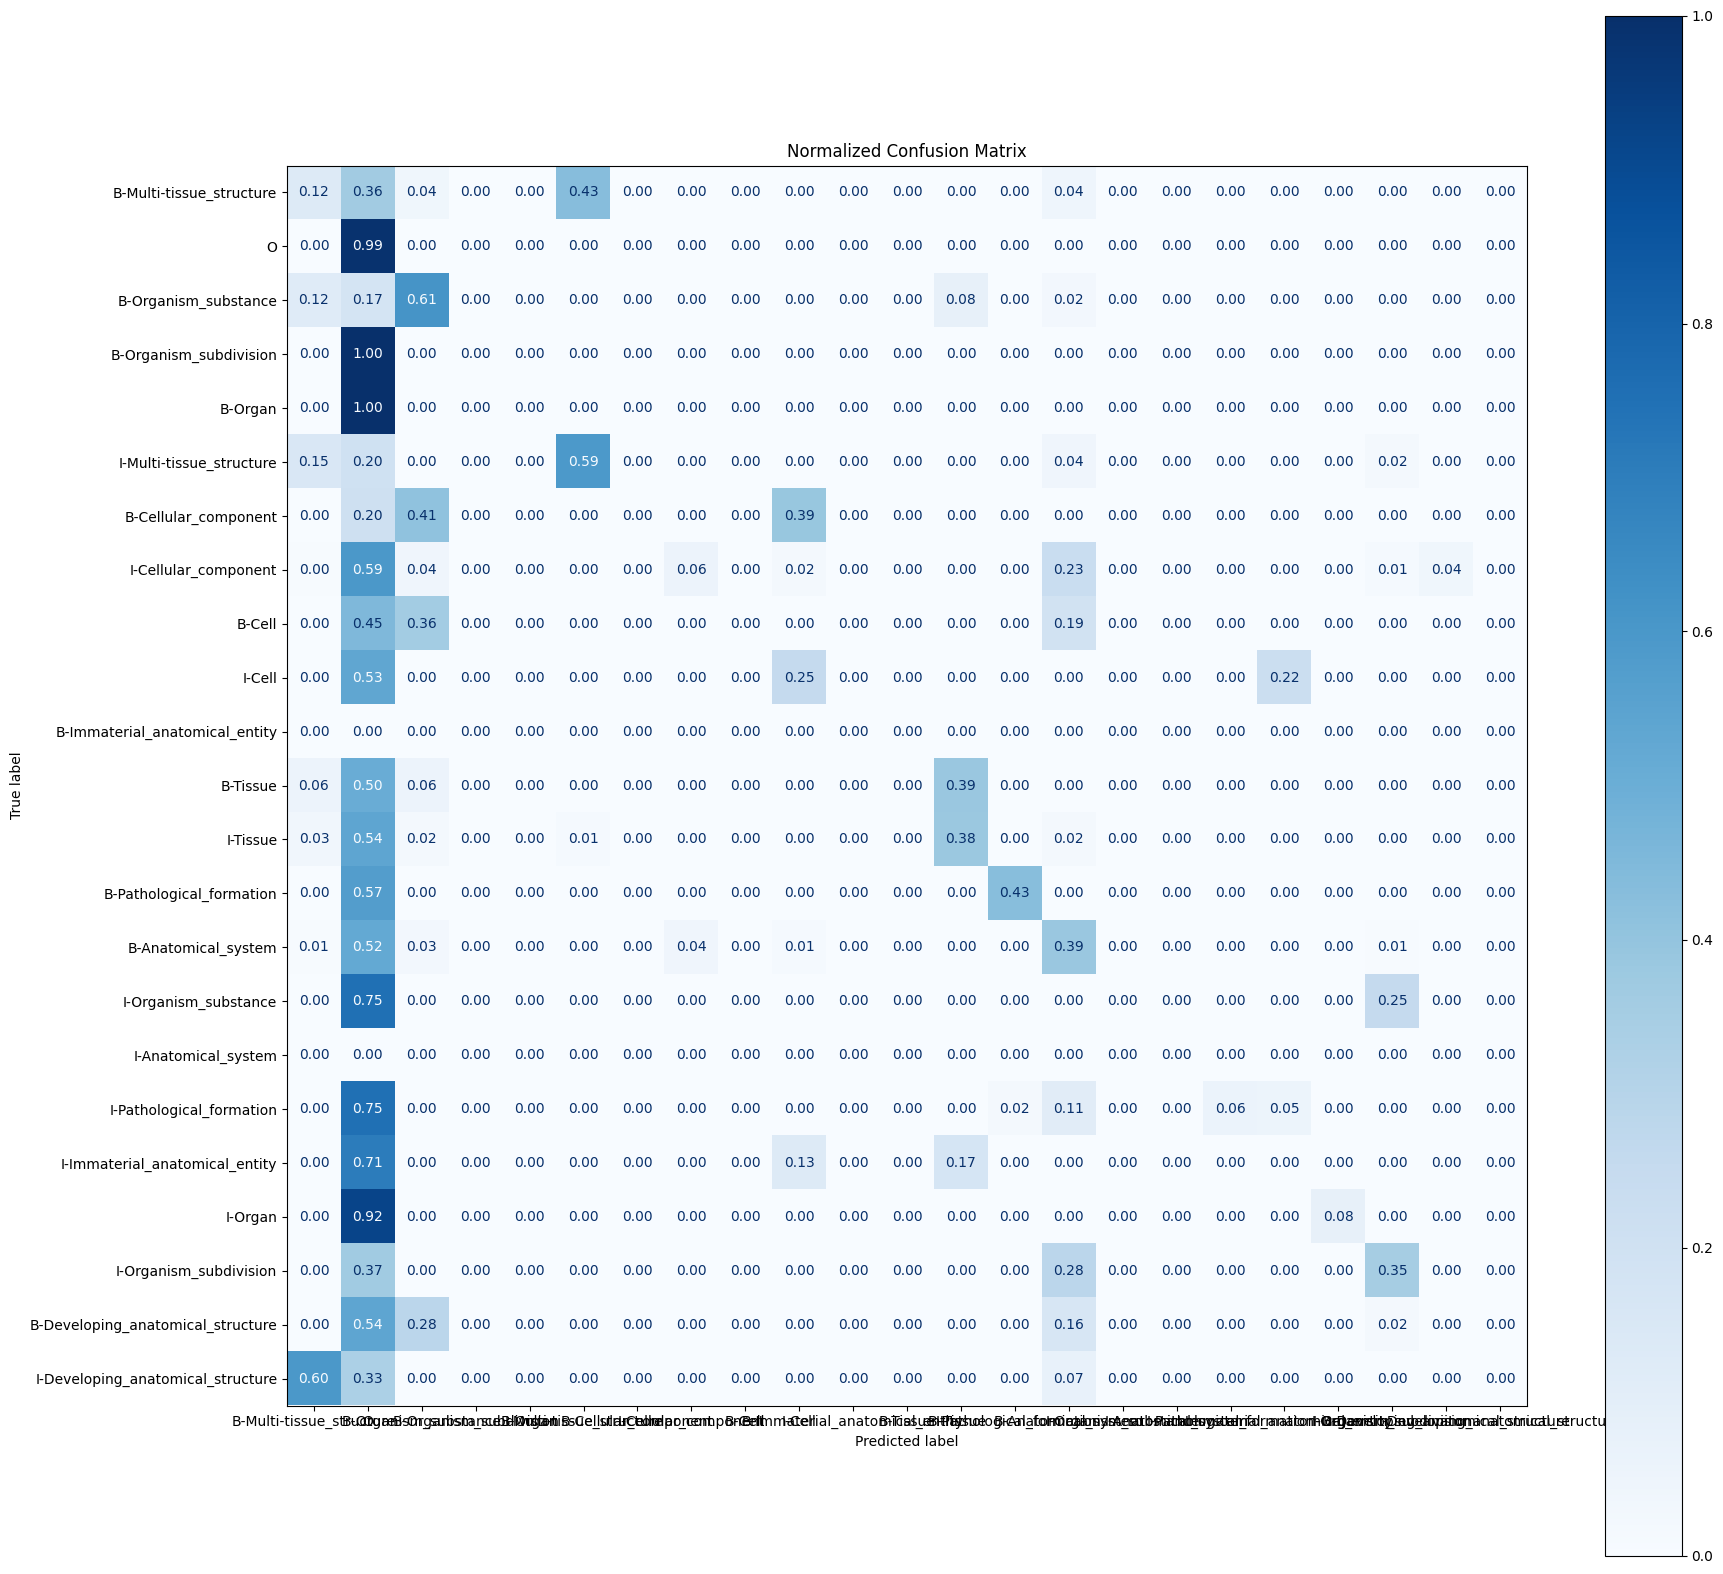

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, labels=labels, normalize="true")
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
    plt.title("Normalized Confusion Matrix")
    plt.show()

# Step 1: Get predictions and ground truth
test_predictions = trainer_tuned.predict(tokenized_datasets['test'])

# Step 2: Retrieve label names correctly
try:
    label_names = tokenized_datasets['train'].features['labels'].feature.names  # Check for ClassLabel
except AttributeError:
    label_names = ['B-Multi-tissue_structure', 'O', 'B-Organism_substance',
 'B-Organism_subdivision', 'B-Organ', 'I-Multi-tissue_structure',
 'B-Cellular_component', 'I-Cellular_component', 'B-Cell', 'I-Cell',
 'B-Immaterial_anatomical_entity', 'B-Tissue', 'I-Tissue',
 'B-Pathological_formation', 'B-Anatomical_system', 'I-Organism_substance',
 'I-Anatomical_system', 'I-Pathological_formation',
 'I-Immaterial_anatomical_entity', 'I-Organ', 'I-Organism_subdivision',
 'B-Developing_anatomical_structure', 'I-Developing_anatomical_structure']

# Step 3: Convert predictions and labels to tag names
true_labels = []
predicted_labels = []

# Iterate through the predictions and labels
for prediction, label in zip(test_predictions.predictions, tokenized_datasets['test']['labels']):
    prediction = np.argmax(prediction, axis=1)  # Convert logits to label indices
    # Filter out the padding tokens and map indices to label names
    for i, (l, p) in enumerate(zip(label, prediction)):
        if l != -100:  # Exclude padding tokens from true labels
            true_labels.append(label_names[l])  # Convert true label index to name

            # Check if prediction index is within bounds
            if p < len(label_names):  # Added a check before accessing label_names
                predicted_labels.append(label_names[p])  # Convert predicted label index to name
            else:
                print(f"Warning: Prediction index {p} is out of bounds for label_names.")

# Step 4: Check if the number of labels match
print("Number of true labels:", len(true_labels))
print("Number of predicted labels:", len(predicted_labels))

# Step 5: Plot the confusion matrix
plot_confusion_matrix(predicted_labels, true_labels, labels=label_names)


In [ ]:
# Specificare la directory dove sono salvati i file ("./sample_data" è la mia ad esmpio)
model_directory = "/content/drive/MyDrive"

# Caricare il modello fine-tunato e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(model_directory)

#CODICE DI MICHELE

In [ ]:
import torch

def predict_lbl(sentence):
    # Ensure the model is on the correct device (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Move the model to the same device

    # Tokenizzare la frase
    inputs = tokenizer.encode_plus(
        sentence,
        return_tensors='pt',             # Restituisce l'output come tensori PyTorch
        is_split_into_words=False,       # Input è una frase completa
        truncation=True,
        max_length=28                    # Lunghezza max usata durante l'addestramento
    )

    # Move the input_ids and attention_mask to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)  # Ensure attention_mask is also moved to the correct device

    model.eval()  # Set model to evaluation mode to disable gradient computation

    # Ottenere le predizioni
    with torch.no_grad():  # Disable gradient calculations to save memory
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Pass both inputs to the model
    predictions = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()  # Move predictions to CPU

    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Ricostruire le parole dai sub-token e assegnare le etichette
    words = []
    labels = []
    for idx, (token, pred) in enumerate(zip(tokens, predictions)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
        if token.startswith('##'):
            words[-1] += token[2:]  # Merge sub-tokens
        else:
            words.append(token)
            labels.append(id2tag[pred])

    # Stampare le parole e le relative etichette
    print("\nPredizione:")
    print("Parola\tEtichetta")
    for word, label in zip(words, labels):
        print(f"{word}\t{label}")


# Esempio di predizione
test_sentence = "Omr ventricular rhino cozk"
predict_lbl(test_sentence)



Predizione:
Parola	Etichetta
Omr	B-Multi-tissue_structure
ventricular	B-Multi-tissue_structure
rhino	O
cozk	O


In [ ]:
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        # Tokenize the sentence
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,       # Add [CLS], [SEP] tokens for BERT
            truncation=True,
            max_length=self.max_len,       # Max length for padding/truncation
            padding='max_length',          # Pad to max_length
            return_attention_mask=True,    # Return attention mask
            return_tensors='pt',           # Return PyTorch tensors
        )

        # Ensure the label length matches the input_ids length
        # Padding the label to match the input_ids length
        label_tensor = label + [-100] * (self.max_len - len(label))  # Using -100 for padding token (ignore in loss)

        # Convert to tensor
        label_tensor = torch.tensor(label_tensor, dtype=torch.long)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label_tensor,
        }

# Example sentences and labels (replace with your actual data)
sentences = ["Hello world", "This is a test sentence"]
labels = [[0, 0], [0, 1, 0]]  # Example: 0 for non-NER and 1 for NER (adjust based on your task)

# Initialize the dataset
train_dataset = NERDataset(sentences=sentences, labels=labels, tokenizer=tokenizer)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class GRUNERModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.2):
        super(GRUNERModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional GRU
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.rnn(embedded)
        output = self.fc(output)
        return output

# Initialize model
vocab_size = len(tokenizer.vocab)  # Number of words in the vocabulary
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_names)  # Number of output labels

gru_model = GRUNERModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Training the GRU model
def train_gru_model(train_dataloader, model, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids, labels = batch
            output = model(input_ids)
            loss = criterion(output.view(-1, output_dim), labels.view(-1))
            loss.backward()
            optimizer.step()

# Example training loop for GRU
optimizer = Adam(gru_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding token
train_gru_model(train_dataloader, gru_model, criterion, optimizer)

# After training, evaluate the GRU model on the test set and compare it with the transformer


ValueError: too many values to unpack (expected 2)

In [ ]:
def evaluate_model(model, dataloader, tokenizer):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            output = model(input_ids)
            preds = torch.argmax(output, dim=2)

            for label, pred in zip(labels, preds):
                true_labels.extend([label_names[l] for l in label if l != -100])
                predicted_labels.extend([label_names[p] for p in pred if p != -100])

    # Compute performance metrics (e.g., precision, recall, F1-score)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

# Evaluate both models
transformer_metrics = evaluate_model(model_fine_tuned, test_dataloader, tokenizer)
gru_metrics = evaluate_model(gru_model, test_dataloader, tokenizer)

print("Transformer Model Metrics:", transformer_metrics)
print("GRU Model Metrics:", gru_metrics)
